### Imports

In [1]:
import os
from skimage.io import imread
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from time import time

## Load images from npz files

In [2]:
with np.load('flo_image_1.npz') as im_data:
    image_dict = dict(zip(im_data['image_ids'], im_data['image_stack']))
print('Loaded',len(image_dict), 'images')

Loaded 800 images


In [3]:
with np.load('flo_image_2.npz') as im_data:
    image_dict2 = dict(zip(im_data['image_ids'], im_data['image_stack']))
print('Loaded',len(image_dict2), 'images')

Loaded 885 images


In [4]:
image_dict.update(image_dict2)

In [5]:
len(image_dict)

1685

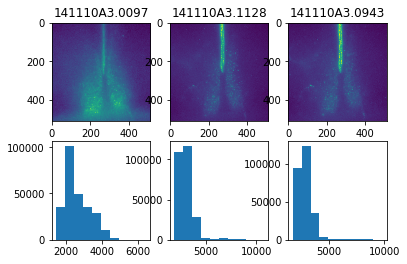

In [6]:
# show a few test images
fig, m_axs = plt.subplots(2,3)
for (ax1, ax2), (img_name, img_data) in  zip(m_axs.T, image_dict.items()):
    ax1.imshow(img_data)
    ax1.set_title(img_name)
    ax2.hist(img_data.ravel())
plt.show()

## Build a dataframe of all images

In [8]:
time_df = pd.read_csv('data141110.csv')
time_df['path'] = time_df['Image.No.'].map(lambda x: "141110A3.%04d" % (x))
time_df['loaded'] = time_df['path'].map(lambda x: x in image_dict)
valid_time_df = time_df.query('loaded')

In [9]:
valid_time_df.head()

,Image.No.,Frame.No,Time.hrs.,path,loaded
0,40,1,3.750892,141110A3.0040,True
1,44,2,3.846050,141110A3.0044,True
2,45,3,3.946050,141110A3.0045,True
3,46,4,4.046050,141110A3.0046,True
4,47,5,4.146050,141110A3.0047,True


### Calculate mean intensity and standard deviation per image

In [10]:
valid_time_df['mean_intensity'] = valid_time_df['path'].map(lambda x: np.mean(image_dict[x]))
valid_time_df['std_intensity'] = valid_time_df['path'].map(lambda x: np.std(image_dict[x]))

In [25]:
valid_time_df.head()

,Image.No.,Frame.No,Time.hrs.,path,loaded,mean_intensity,std_intensity
0,40,1,3.750892,141110A3.0040,True,2450.778805,413.650524
1,44,2,3.846050,141110A3.0044,True,2411.383465,419.041849
2,45,3,3.946050,141110A3.0045,True,2393.520092,429.238393
3,46,4,4.046050,141110A3.0046,True,2350.644688,433.929205
4,47,5,4.146050,141110A3.0047,True,2337.459301,440.732899


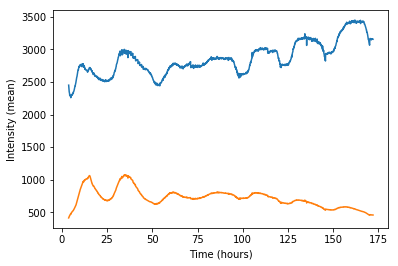

In [11]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(valid_time_df['Time.hrs.'], valid_time_df['mean_intensity'])
ax1.plot(valid_time_df['Time.hrs.'], valid_time_df['std_intensity'])
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Intensity (mean)')
plt.show()

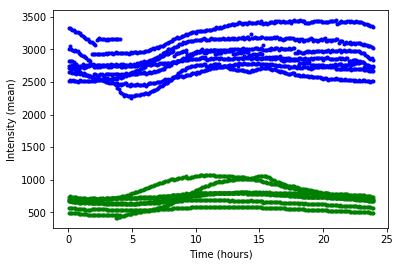

In [12]:
# if we show the data mod 24 do we see stronger trends 
fig, ax1 = plt.subplots(1,1)
ax1.plot(np.mod(valid_time_df['Time.hrs.'], 24), valid_time_df['mean_intensity'], 'b.')
ax1.plot(np.mod(valid_time_df['Time.hrs.'], 24), valid_time_df['std_intensity'], 'g.')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Intensity (mean)')
plt.show()

### Look at distribution of one image

In [13]:
pic = image_dict['141110A3.0040']

In [14]:
len(pic[0])

512

Pics are 512 x 512

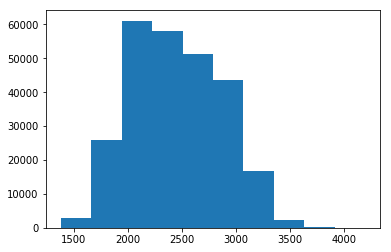

In [15]:
flat_pic = [pixel for row in pic for pixel in row]
plt.hist(flat_pic)
plt.show()

In [16]:
np.mean(pic)

2450.7788047790527

## Extract small squares of an image

In [17]:
sq = [row[:8] for row in pic[:8]]

In [18]:
squares_df = valid_time_df.copy()

16x16 pixel squares

In [19]:
def get_squares(image, size=16):
    squares = []
    i = 0
    while i < 512:
        j = 0
        while j < 512:
            squares.append([row[j:j+size] for row in image[i:i+size]])
            j += size
        i += size
    return squares

In [29]:
sqrs = get_squares(pic)

In [30]:
len(sqrs)

1024

In [31]:
np.mean(sqrs[0])

1713.8046875

In [32]:
def write_squares_means(df, size=16):
    # write mean intensity of all squares of given size into df
    # this is very slow
    paths = df['path']
    for square_num in range(size**2):
        df['mean_sq{}'.format(square_num)] = np.nan
        
    start = time()
    for index in range(1685):
        sqrs = get_squares(image_dict[df['path'][index]])
        for square_num in range(size**2):
            df['mean_sq{}'.format(square_num)][index] = np.mean(sqrs[square_num])
    return time()-start

In [23]:
len(valid_time_df)

1685

See what an 8x8 square will look like

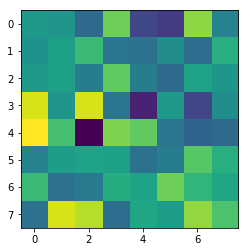

In [32]:
plt.imshow([row[:8] for row in sqrs[200][:8]])
plt.show()

A 16x16 square

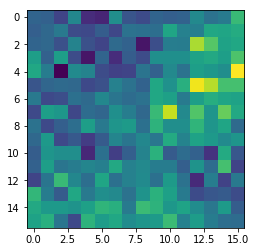

In [33]:
plt.imshow(sqrs[200])
plt.show()

### An example figure for the report

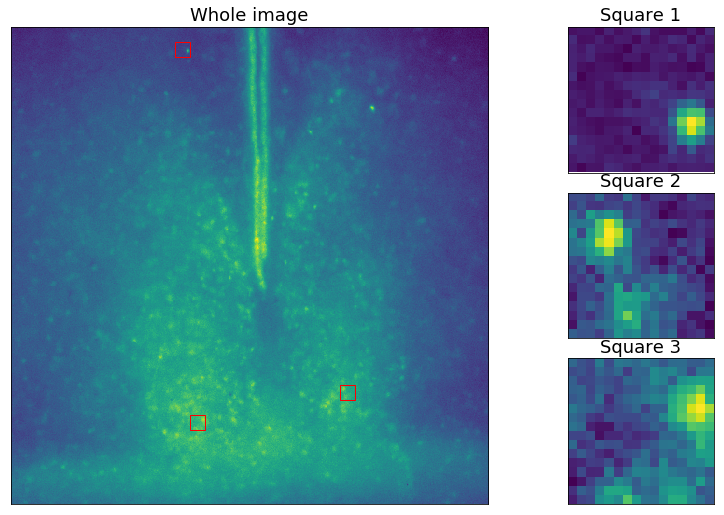

In [36]:
# Plot figure with subplots of different sizes
fig, a = plt.subplots(1,1, figsize=(12,12))
# set up subplot grid
gridspec.GridSpec(3,3)

# large subplot
ax = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
plt.title('Whole image', fontsize=18)
plt.xticks([])
plt.yticks([])
plt.imshow(pic)
rect1 = patches.Rectangle((176,16),16,16,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((192,416),16,16,linewidth=1,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((352,384),16,16,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

# small subplot 1
plt.subplot2grid((3,3), (0,2))
# plt.locator_params(axis='x', nbins=5)
# plt.locator_params(axis='y', nbins=5)
plt.title('Square 1', fontsize=18)
plt.xticks([])
plt.yticks([])
# plt.xlabel('Data values')
# plt.ylabel('Frequency')
plt.imshow([row[176:176+16] for row in pic[16:16+16]])

# small subplot 2
plt.subplot2grid((3,3), (1,2))
plt.title('Square 2', fontsize=18)
plt.xticks([])
plt.yticks([])
plt.imshow([row[352:352+16] for row in pic[384:384+16]])

# small subplot 3
plt.subplot2grid((3,3), (2,2))
plt.title('Square 3', fontsize=18)
plt.xticks([])
plt.yticks([])
plt.imshow([row[192:192+16] for row in pic[416:416+16]])

# fit subplots and save fig
fig.tight_layout()
fig.set_size_inches(w=11,h=7)
# fig.savefig('squares-example.png')

plt.show()